In [ ]:
import os
print("Notebook CWD:", os.getcwd())#


Notebook CWD: d:\CS772 Project\notebooks


In [32]:
import pandas as pd

# 1. Load
df = pd.read_csv('../results/metrics.csv')

# 2. Quick peek
print(df.head())
print(df.is_outlier.value_counts())
print(df[['ae_mse','rho_score','vae_elbo']].describe())


   sample_id  is_outlier    ae_mse  rho_score  vae_recon   vae_kld  vae_elbo
0          0        True  0.000063   0.222950   0.001815  3.300306  0.331845
1          1       False  0.000037   0.169213   0.002083  3.236441  0.325727
2          2       False  0.000048   0.162470   0.002460  3.669784  0.369438
3          3       False  0.000024   0.128647   0.001519  2.802884  0.281808
4          4       False  0.000108   0.347974   0.001724  3.255633  0.327288
is_outlier
False    178077
True      71475
Name: count, dtype: int64
              ae_mse      rho_score       vae_elbo
count  249552.000000  249552.000000  249552.000000
mean        0.000051       0.188217       0.447438
std         0.000081       0.133844       0.257104
min         0.000002       0.013221       0.178244
25%         0.000016       0.094393       0.286737
50%         0.000028       0.139682       0.373082
75%         0.000058       0.237501       0.513345
max         0.007304       0.990099       5.308942


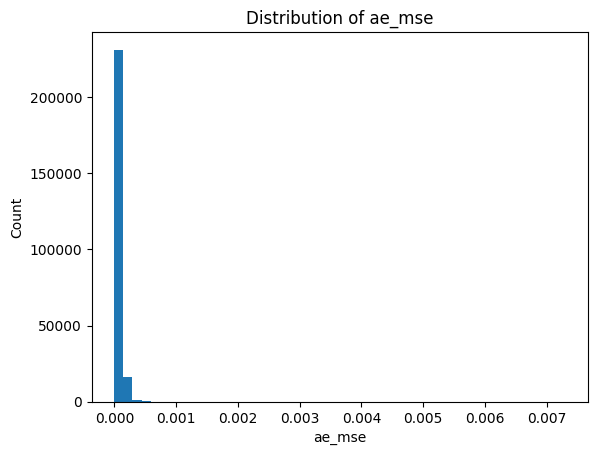

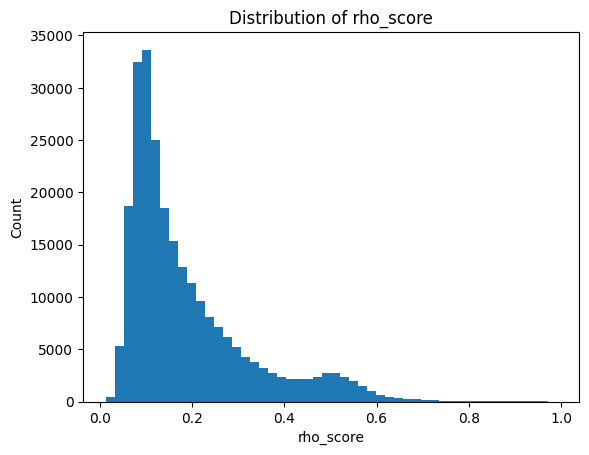

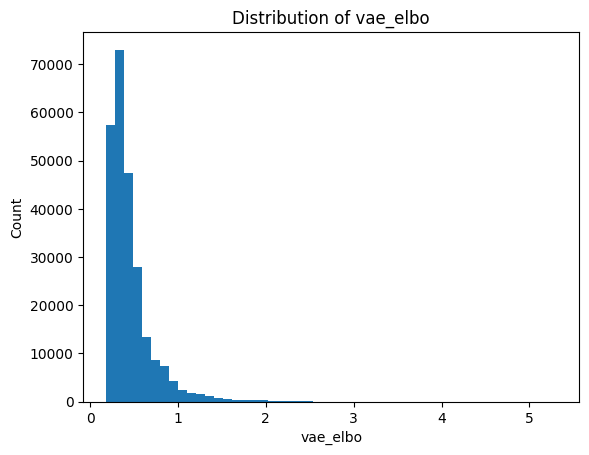

In [33]:
import matplotlib.pyplot as plt

for col in ['ae_mse','rho_score','vae_elbo']:
    plt.figure()
    plt.hist(df[col], bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


In [34]:
# higher MSE → harder; higher RHO-score → harder; higher ELBO → harder
df_ae  = df.sort_values('ae_mse',    ascending=False)
df_rho = df.sort_values('rho_score', ascending=False)
df_vae = df.sort_values('vae_elbo',  ascending=False)

k = int(0.05 * len(df))  # top 5%
print("AE Precision@5%:",  df_ae.iloc[:k]['is_outlier'].mean())
print("RHO Precision@5%:", df_rho.iloc[:k]['is_outlier'].mean())
print("VAE Precision@5%:", df_vae.iloc[:k]['is_outlier'].mean())


AE Precision@5%: 0.6082391600545003
RHO Precision@5%: 0.6060751783281237
VAE Precision@5%: 0.7343912799551174


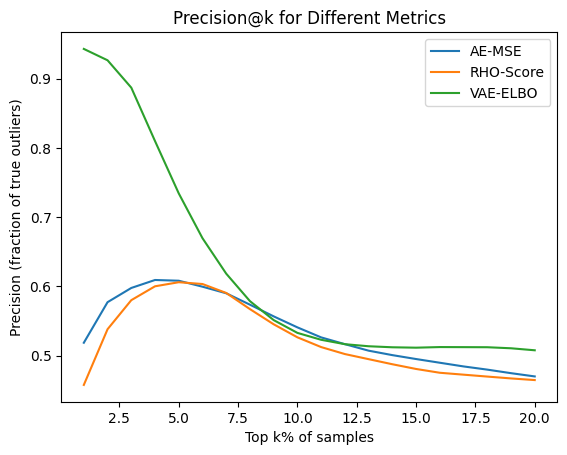

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def precision_at_k(sorted_df, k_frac):
    k = int(k_frac * len(sorted_df))
    return sorted_df.iloc[:k]['is_outlier'].mean()

ks = np.linspace(0.01, 0.20, 20)
precisions = {'AE':[], 'RHO':[], 'VAE':[]}

for k in ks:
    precisions['AE'].append( precision_at_k(df_ae,  k) )
    precisions['RHO'].append(precision_at_k(df_rho, k) )
    precisions['VAE'].append(precision_at_k(df_vae, k) )

plt.figure()
plt.plot(ks*100, precisions['AE'],  label='AE-MSE')
plt.plot(ks*100, precisions['RHO'], label='RHO-Score')
plt.plot(ks*100, precisions['VAE'], label='VAE-ELBO')
plt.xlabel('Top k% of samples')
plt.ylabel('Precision (fraction of true outliers)')
plt.legend()
plt.title('Precision@k for Different Metrics')
plt.show()


Accuracy@5%:
  AE-MSE    : 0.724
  RHO-Score : 0.724
  VAE-ELBO  : 0.737


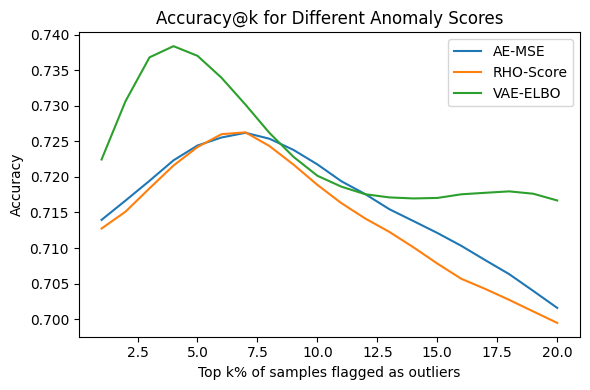

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. True labels and score arrays
y_true = df['is_outlier'].astype(int).values
score_dict = {
    'AE-MSE':  df['ae_mse'].values,
    'RHO-Score': df['rho_score'].values,
    'VAE-ELBO':  df['vae_elbo'].values
}

# 2. Accuracy@k helper
def accuracy_at_k(scores, y_true, k_frac):
    n = len(scores)
    k = int(k_frac * n)
    if k == 0:
        return accuracy_score(y_true, np.zeros_like(y_true))
    thresh = np.sort(scores)[-k]
    y_pred = (scores >= thresh).astype(int)
    return accuracy_score(y_true, y_pred)

# 3. Print Accuracy@5%
k = 0.05
print(f"Accuracy@{int(k*100)}%:")
for name, scores in score_dict.items():
    acc = accuracy_at_k(scores, y_true, k)
    print(f"  {name:10s}: {acc:.3f}")

# 4. Plot Accuracy@k curves (1% to 20%)
ks = np.linspace(0.01, 0.20, 20)
plt.figure(figsize=(6,4))
for name, scores in score_dict.items():
    accs = [accuracy_at_k(scores, y_true, k_frac) for k_frac in ks]
    plt.plot(ks*100, accs, label=name)
plt.xlabel('Top k% of samples flagged as outliers')
plt.ylabel('Accuracy')
plt.title('Accuracy@k for Different Anomaly Scores')
plt.legend()
plt.tight_layout()
plt.show()
